In [1]:
# !pip uninstall --yes fastcore && pip install --upgrade git+git://github.com/fastai/fastcore.git 

In [2]:
# !pip uninstall --yes fastai2 && pip install --upgrade git+git://github.com/fastai/fastai2.git

# Hebrew ULMFiT from scratch

In [3]:
%load_ext autoreload
%autoreload 2
from fastai2.basics import *
from fastai2.text.all import *
torch.cuda.set_device(0)

In [4]:
bs = 96
wd = 1e-1
moms = (0.95, 0.85, 0.95)#(0.8,0.7,0.8)#
seq_len = 72

In [5]:
lang = 'he'
data_path = Config.config_path/'data'
name = f'{lang}wiki'
tok = 'SP_fwd_qrnn_v2'
text_path = data_path/name
path = Path(f'{data_path}/{name}_{tok}')
data_format = 'token' #morph or token
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt_{tok}', f'{lang}_wt_vocab_{tok}']

## Hebrew wikipedia model

### Create pretrained model

In [6]:
# tokenize_folder(text_path, output_dir=path, tok_func=SentencePieceTokenizer, lang='he',
                #max_vocab_sz=15000,
#                 sp_model=None)

In [7]:
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): 
        super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
    
    
def backwards(tokens): return tokens.flip(0)

In [8]:
counter = pickle.load(open(str(path/'counter.pkl'), 'rb'))
vocab = make_vocab(counter)
len(vocab)

31136

In [ ]:
# texts = get_text_files(path)
# splits = RandomSplitter(valid_pct=0.01, seed=42)(texts)
# x_tfms = [Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
#           Numericalize(vocab=vocab)]
# dsets = Datasets(texts, [x_tfms], splits=splits, dl_type=LMDataLoader)
# data = dsets.dataloaders(bs=bs, seq_len=seq_len)

In [ ]:
# learn = language_model_learner(data, AWD_QRNN, metrics=[accuracy, Perplexity()], path=path,
#                                drop_mult=0., pretrained=False)

In [ ]:
# learn.unfreeze()
# learn.lr_find()

In [ ]:
# lr = 1e-3
# lr *= bs/48  # Scale learning rate by batch size

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(15, lr, wd=wd, moms=(0.8,0.7,0.8))

In [ ]:
# learn.show_results()

In [ ]:
# mdl_path = path/'models'
# mdl_path.mkdir(exist_ok=True)
# learn.save(mdl_path/lm_fns[0], with_opt=False)
# with open(mdl_path/(lm_fns[1] + '.pkl'), 'wb') as f:
#     pickle.dump(learn.dls.vocab, f)

Save the pretrained model and vocab:

## Hebrew sentiment analysis

### Language model

In [ ]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
train_df.head()

In [ ]:
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df.head()

In [ ]:
full_df = pd.concat([train_df,test_df], sort=False)

In [ ]:
full_df = full_df.rename(columns={'comment': 'text'})
full_df.head()

In [ ]:
tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab),
        backwards]
splits = RandomSplitter(valid_pct=0.01, seed=42)(full_df)
dsrc = Datasets(full_df, [tfms], splits=splits, dl_type=LMDataLoader)
data_ft = dsrc.dataloaders(bs=bs, seq_len=seq_len)

In [ ]:
learn_lm = language_model_learner(data_ft, AWD_QRNN, metrics=[accuracy], path=path,
                                  opt_func = partial(Adam, wd=0.1),
                                  drop_mult=0.5, pretrained_fnames=lm_fns)
learn_lm.loss_func = LabelSmoothingCrossEntropyFlat()#CrossEntropyLossFlat()#

In [ ]:
learn_lm.lr_find()

In [ ]:
lr = 2e-1
lr *= bs/48
n_epochs = 4

In [ ]:
learn_lm.fit_one_cycle(n_epochs, lr, wd=wd, moms=moms)

In [ ]:
learn_lm.unfreeze()
lr /= 5
learn_lm.fit_one_cycle(2*n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms)

In [ ]:
learn_lm.save(f'{lang}fine_tuned_bwd_{tok}_{data_format}')
learn_lm.save_encoder(f'{lang}fine_tuned_bwd_enc_{tok}_{data_format}')

### Classifier

Full train set
--

In [9]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
train_df['is_valid'] = False
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df['is_valid'] = True

df = pd.concat([train_df,test_df], sort=False).rename(columns={'comment': 'text'})

In [10]:
bs = 32
splits = ColSplitter()(df)
x_tfms = [attrgetter('text'),
         Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
         Numericalize(vocab),
         backwards]
dsrc = Datasets(df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=splits, dl_type=SortedDL)
cls_data = dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len)

In [11]:
drop = 0.5
wd = 0.1
pretrained = False
loss_func = LabelSmoothingCrossEntropyFlat()#CrossEntropyLossFlat()#
cbs = SaveModelCallback('accuracy')
learn_c = text_classifier_learner(cls_data, AWD_QRNN, 
                                  metrics=[accuracy, BalancedAccuracy()],
                                  path=path,
                                  loss_func=loss_func,
                                  drop_mult=drop, pretrained=pretrained, wd=wd)
learn_c = learn_c.load_encoder(f'{lang}fine_tuned_bwd_enc_{tok}_{data_format}')

(0.017378008365631102, 0.0831763744354248)

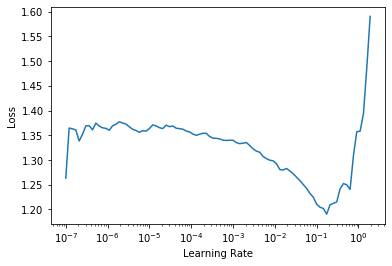

In [12]:
learn_c.lr_find()

In [13]:
lr = 3e-2
lr *= bs/48
n_epochs = 10
div = 10.0

In [14]:
learn_c.fit_one_cycle(n_epochs, lr, wd=wd, cbs=cbs)
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, cbs=cbs)
learn_c.freeze_to(-3)
lr /= 2
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, cbs=cbs)
learn_c.freeze_to(-4)
lr /= 2
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, cbs=cbs)
learn_c.unfreeze()
lr /= 5
learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, cbs=cbs)
learn_c.validate()

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.853889,0.615072,0.831641,0.593288,00:09
1,0.866731,0.600939,0.819922,0.546652,00:09
2,0.818344,0.668634,0.797656,0.541609,00:09
3,0.860645,0.629195,0.778516,0.564511,00:10
4,0.848406,0.597440,0.835938,0.597015,00:10
5,0.828261,0.617234,0.831641,0.599740,00:09
6,0.823312,0.604104,0.830078,0.606389,00:10
7,0.817216,0.600976,0.845312,0.676575,00:10
8,0.821993,0.582493,0.847266,0.657646,00:10
9,0.794178,0.566133,0.850781,0.697520,00:10


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.713629,0.581578,0.844141,0.678614,00:10
1,0.714566,0.581541,0.844531,0.646423,00:10
2,0.638654,0.568928,0.843359,0.575499,00:09
3,0.651437,0.544079,0.865234,0.735073,00:10
4,0.601369,0.546441,0.858203,0.601527,00:09
5,0.596231,0.518815,0.880078,0.709322,00:10
6,0.547166,0.511231,0.885156,0.715631,00:10
7,0.570127,0.499707,0.887500,0.713198,00:10
8,0.547247,0.518622,0.873438,0.689062,00:10
9,0.513975,0.488319,0.901563,0.732675,00:10


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.517425,0.512391,0.886719,0.714903,00:12
1,0.530463,0.504150,0.892969,0.763890,00:13
2,0.512070,0.518519,0.894922,0.708513,00:12
3,0.501199,0.477304,0.907812,0.755208,00:13
4,0.457108,0.484463,0.914062,0.769539,00:14
5,0.453027,0.465576,0.925391,0.787032,00:13
6,0.452346,0.463854,0.921484,0.764177,00:14
7,0.409767,0.465026,0.927734,0.785807,00:13
8,0.388444,0.462335,0.933203,0.803660,00:12
9,0.394246,0.454992,0.935156,0.805093,00:12


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.406906,0.460906,0.932422,0.791242,00:17
1,0.405241,0.477672,0.932031,0.802620,00:18
2,0.396976,0.456616,0.933984,0.816676,00:19
3,0.400875,0.455164,0.934375,0.811842,00:18
4,0.380926,0.447167,0.936328,0.807713,00:18
5,0.381248,0.450500,0.935938,0.810596,00:18
6,0.384801,0.459829,0.936328,0.802975,00:18
7,0.350863,0.440440,0.940625,0.820318,00:16
8,0.362427,0.445465,0.938281,0.817335,00:19
9,0.358458,0.452641,0.935547,0.810772,00:17


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.355295,0.440180,0.940625,0.820093,00:24
1,0.372905,0.441721,0.936328,0.813872,00:26
2,0.373531,0.451932,0.933594,0.808290,00:26
3,0.351192,0.444627,0.937500,0.815815,00:27
4,0.359785,0.445846,0.934766,0.811959,00:23
5,0.351801,0.455471,0.933594,0.814675,00:22
6,0.342675,0.451182,0.939453,0.819278,00:24
7,0.351643,0.452429,0.939844,0.817444,00:23
8,0.337362,0.445123,0.938281,0.813353,00:22
9,0.342938,0.449798,0.939453,0.822358,00:24


(#3) [0.4401804804801941,0.940625011920929,0.8200926795651041]

In [ ]:
# lr /= 2
# learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, cbs=cbs)
# learn_c.validate()

In [ ]:
# lr /= 2
# learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, cbs=cbs)
# learn_c.validate()

In [ ]:
# lr /= 2
# learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, cbs=cbs)
# learn_c.validate()

In [ ]:
# learn_c.save(f'{lang}clas_bwd_{tok}_{data_format}_traintest')

In [15]:
from fastai2.interpret import *
interp = ClassificationInterpretation.from_learner(learn_c)
interp.plot_top_losses(50)

,input,target,predicted,probability,loss
0,▁החברתית נו ▁ארצ ▁וארגון נכים ▁ ▁למען נכים ▁ רש ▁לחי ▁תנו עמותת ▁מ ▁לכולם ▁שלום ▁שבת ▁xxbos,0,2,0.9999606609344482,10.239203453063965
1,"s el ra is ics polit ▁ ▁/ com . book face . ▁m ▁/ ▁/ : s http ▁ ; ▁ ▁״ ▁פוליטיקאים ▁של צים ו ▁צי ▁״ ! ▁ ▁אחד דף ▁ב ▁והכל , ▁ ▁בישראל פוליטיקאים ▁ה ▁כל ▁של עניינים ▁המ צים ו ▁הצי ▁כל ▁את ו קבל ות ▁ קישור ▁ל ▁עכשיו ו ▁כנס ! ▁ כם ▁בשביל ▁בדיוק ▁מיועד ▁״ ▁פוליטיקאים ▁של צים ו ▁צי ▁״ ▁הדף ? ? ▁ פוליטיקה ▁ ים ▁אוהב ▁xxbos",0,2,0.9986623525619507,6.564102649688721
2,. ▁ ▁לחיות ן ות ▁ ▁חיה ! ! ▁ קוף ת ▁ול ▁לפגוע ▁בלי ▁דעה ▁להביע עיקר ▁ה ך מו ▁שית ▁מי ך מו ית ▁ו נגד ▁שית ▁מי נגד ▁שית ▁... ▁אמיתי קיום - ▁לדו תקווה ▁ו ▁המנהרה ▁בקצה ▁האור ▁הוא ▁האלה ים ▁האזרחי נישואים ▁ב ך ▁של ▁הדעה ▁אך ▁... ▁קלים ▁לא ▁ימים ים ▁ועובר כולנו ▁ל ▁קשה ▁הזאת ▁במדינה ות ▁שהמציא ▁ספק ▁אין ▁... קול ▁וש ▁נבון ▁מנהיג ▁עם תנהל ▁לה ▁אמורה ת קרטי מו ▁די ▁מדינה ▁כך ▁... ▁לך ים יע ▁מצד ▁... ▁לך ▁הכבוד ▁כל ▁... ▁ריבלין ▁מר ▁הנשיא ▁כבוד ▁xxbos,1,0,0.9609808921813965,5.149613857269287
3,. ▁ ▁לחיות ן ות ▁ ▁חיה ! ! ▁ קוף ת ▁ול ▁לפגוע ▁בלי ▁דעה ▁להביע עיקר ▁ה ך מו ▁שית ▁מי ך מו ית ▁ו נגד ▁שית ▁מי נגד ▁שית ▁... ▁אמיתי קיום - ▁לדו תקווה ▁ו ▁המנהרה ▁בקצה ▁האור ▁הוא ▁האלה ים ▁האזרחי נישואים ▁ב ך ▁של ▁הדעה ▁אך ▁... ▁קלים ▁לא ▁ימים ים ▁ועובר כולנו ▁ל ▁קשה ▁הזאת ▁במדינה ות ▁שהמציא ▁ספק ▁אין ▁... קול ▁וש ▁נבון ▁מנהיג ▁עם תנהל ▁לה ▁אמורה ת קרטי מו ▁די ▁מדינה ▁כך ▁... ▁לך ים יע ▁מצד ▁... ▁לך ▁הכבוד ▁כל ▁... ▁ריבלין ▁מר ▁הנשיא ▁כבוד ▁xxbos,1,0,0.9609808921813965,5.149613857269287
4,"▁"" . ▁ ▁"" ▁"" ▁מישראל ▁"" ▁"" ▁המילה ת ▁נעדר ▁שבו ▁נוסח ▁נותן , ▁ ] ▁ ▁4 ▁[ ) ▁ ▁יב ▁פרק סנהדרין ▁ ▁הלכות ▁( ▁תורה ▁משנה ▁בספרו , ▁ ם "" "" ▁הרמב . ▁ ▁"" ▁"" ▁מלא ▁עולם ▁קיים ▁כאילו ▁עליו ים ▁מעל , ▁ ▁מישראל ▁אחת ▁נפש יים ▁המק ▁וכל ; ▁ ▁מלא ▁עולם ▁איבד ▁כאילו ▁עליו ים ▁מעל , ▁ ▁מישראל ▁אחת ▁נפש אבד ▁המ ▁כל ▁"" ▁"" ▁הנוסח קבל ▁ומת , ▁ ▁"" ▁"" ▁מישראל ▁"" ▁"" ▁המילה ▁נוספת ] ▁ ▁3 ▁[ ▁הבבלי ▁התלמוד ▁של ▁דפוס ▁בגרסאות ▁אך , ▁ ] ▁ ▁2 ▁[ ▁זה ▁בנוסח ▁המשנה ת מצוטט ▁ ▁הירושלמי ▁התלמוד ▁של ▁דפוס ▁בגרסאות ▁וגם ▁המשנה ▁של מה ▁פר ▁יד כתב ▁וב ▁קאופמן ▁יד ▁בכתב ▁הנוסח ▁זהו . ▁ ] ▁ ▁1 ▁[ ▁"" ▁"" ▁מלא ▁עולם ▁קיים ▁כאילו ▁עליו ים ▁מעל , ▁ ▁אחת ▁נפש יים ▁המק ▁וכל ;",1,2,0.8922808766365051,4.9308624267578125
5,) ▁ : ▁ ות מחשב ▁מה ▁המילים ▁את ▁לי ' ת ▁גנב ' ▁ ▁xxbos,1,0,0.9682201147079468,4.402817249298096
6,! ▁ ות בוט ▁ה ▁על בייש ▁תת עד ▁אבי ▁xxbos,0,2,0.590831995010376,4.360429286956787
7,"▁"" ▁בסיכון ת ובל ▁שג ▁ברמה ביל ▁ד ה ▁את ▁אז ▁"" ▁"" ני ▁שמאל ▁"" ▁זה ▁מתים ▁הערבים ▁כל ▁את ▁לרצות ▁שלא ▁מחליט ה ▁את ▁אם ם מט ▁מטו , ▁ וואי ▁ ▁xxbos",0,1,0.9608935117721558,4.144609451293945
8,"▁"" ▁"" ▁"" . ▁ בייש ▁להת ▁בלי ▁"" ▁"" ▁"" ▁התקווה ▁את ▁ישיר ▁ערבי שחקן ▁ש ▁חלום ▁לי ▁יש ▁xxbos",0,1,0.9623586535453796,3.9363646507263184
9,▁מסוכן ▁ערבי ▁זה ▁ערבי ים ▁בוגד ▁הם ▁לך ▁מתאים ▁לא טיבי ▁מ ה ▁תרפ ▁זה ▁את ח ▁תשכ ▁על ▁חזק ▁ימני ניק ליכוד ▁ ▁בדם ה ▁את ▁חושבים ▁שכולם ▁כמו ה ▁שמאל פנה ▁ת ▁שלא ▁מקווה ▁אני ▁רובי ▁xxbos,0,1,0.9645482897758484,3.7125227451324463


In [16]:
test_df.iloc[np.array(interp.dl.get_idxs())[interp.top_losses(k=50)[1]]].drop_duplicates()

,comment,label,is_valid
1792,שבת שלום לכולם מעמותת תנו לחירש נכים למען נכים וארגון ארצנו החברתית,0,True
1474,"אוהבים פוליטיקה ?? הדף ״ ציוצים של פוליטיקאים ״ מיועד בדיוק בשבילכם ! כנסו עכשיו לקישור ותקבלו את כל הציוצים המעניינים של כל הפוליטיקאים בישראל , והכל בדף אחד ! ״ ציוצים של פוליטיקאים ״ ; https://m.facebook.com/politicsisraels",0,True
2108,כבוד הנשיא מר ריבלין ... כל הכבוד לך ... מצדיעים לך ... כך מדינה דימוקרטית אמורה להתנהל עם מנהיג נבון ושקול ... אין ספק שהמציאות במדינה הזאת קשה לכולנו ועוברים ימים לא קלים ... אך הדעה שלך בנישואים האזרחיים האלה הוא האור בקצה המנהרה ותקווה לדו-קיום אמיתי ... שיתנגד מי שיתנגד ויתמוך מי שיתמוך העיקר להביע דעה בלי לפגוע ולתקוף !! חיה ותן לחיות .,1,True
2081,"במשנה , במסכת סנהדרין ( ד , ה ) נאמר : "" לפיכך נברא אדם יחידי בעולם , ללמד שכל המאבד נפש אחת , מעלים עליו כאילו איבד עולם מלא ; וכל המקיים נפש אחת , מעלים עליו כאילו קיים עולם מלא "" "" [ 1 ] . זהו הנוסח בכתב יד קאופמן ובכתב יד פרמה של המשנה וגם בגרסאות דפוס של התלמוד הירושלמי מצוטטת המשנה בנוסח זה [ 2 ] , אך בגרסאות דפוס של התלמוד הבבלי [ 3 ] נוספת המילה "" "" מישראל "" "" , ומתקבל הנוסח "" "" כל המאבד נפש אחת מישראל , מעלים עליו כאילו איבד עולם מלא ; וכל המקיים נפש אחת מישראל , מעלים עליו כאילו קיים עולם מלא "" "" . הרמב""""ם , בספרו משנה תורה ( הלכות סנהדרין פרק יב ) [ 4 ] , נותן נוסח שבו נעדרת ה...",1,True
1493,' גנבת' לי את המילים מהמחשבות : ),1,True
73,אביעד תתבייש על הבוטות !,0,True
1968,"וואי , מטומטם אם אתה מחליט שלא לרצות את כל הערבים מתים זה "" שמאלני "" "" אז אתה דביל ברמה שגובלת בסיכון """,0,True
57,"יש לי חלום ששחקן ערבי ישיר את התקווה "" "" "" בלי להתבייש . "" "" """,0,True
2354,רובי אני מקווה שלא תפנה שמאלה כמו שכולם חושבים אתה בדם ליכודניק ימני חזק על תשכח את זה תרפה מטיבי לא מתאים לך הם בוגדים ערבי זה ערבי מסוכן,0,True
2011,אני חולה על הביתריסתים בנשמה .,2,True


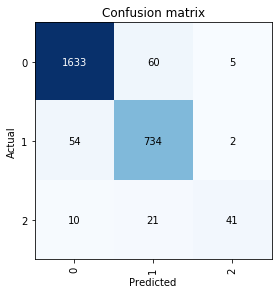

In [17]:
interp.plot_confusion_matrix()

In [ ]:
# 0 - positive
# 1 - negative
# 2 - neutral